*Author:* Evan Yip <br>
*Date Created:* 12/7/2023 <br>
*Purpose:* Loading GDP data from Bureau of Economic Analysis datasets and preparing it for analysis in final analysis notebook.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Step 1. Load the Data
The first step is to load the GDP data from the BEA into Pandas.

In [129]:
# Washington and California imports
sagdp2N_WA = pd.read_csv("../data_raw/SAGDP_03_31_2023/SAGDP2N_WA_1997_2022.csv")
sagdp2N_CA = pd.read_csv("../data_raw/SAGDP_03_31_2023/SAGDP2N_CA_1997_2022.csv")
# Montana gdp imports
sagdp2N_MT = pd.read_csv("../data_raw/SAGDP_03_31_2023/SAGDP2N_MT_1997_2022.csv")
sagdp2S_MT = pd.read_csv("../data_raw/SAGDP_03_31_2023/SAGDP2S_MT_1963_1997.csv")

The first thing we will look at is the breakdown of the GDP in the year 2022 from Montana

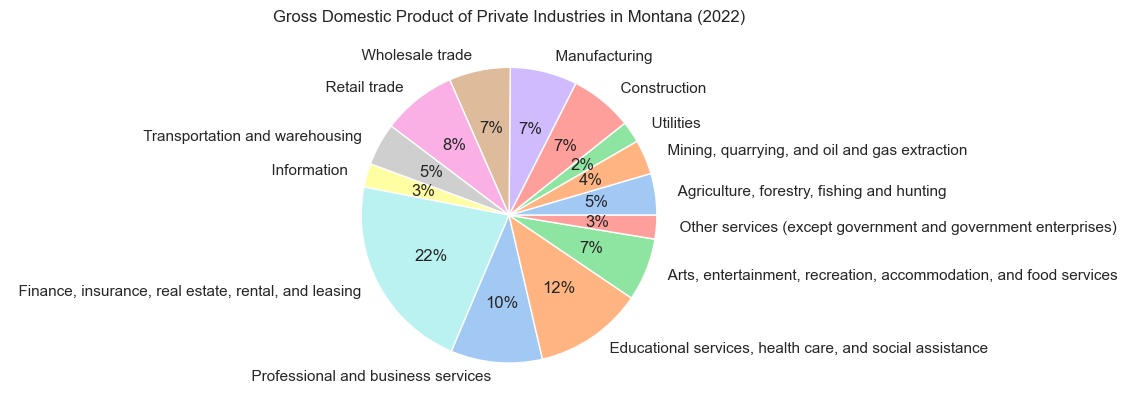

In [122]:
gdp_2022 = sagdp2N_MT[['Description', 'LineCode', 'Unit', '2022']]
gdp_2022 = gdp_2022[gdp_2022['2022'].notna()]
gdp_2022 = gdp_2022[gdp_2022['2022'] != "(NA)"]
gdp_2022['2022'] = gdp_2022['2022'].astype(float)

# Grouping for pie chart
def count_leading_spaces(token):
    num_spaces = 0
    i = 0
    char = token[i]
    while char == ' ':
        num_spaces += 1
        i += 1
        char = token[i]
    return num_spaces

gdp_2022['class'] = gdp_2022['Description'].apply(lambda x: count_leading_spaces(x))
government_services = ['Federal civilian', 'Military', 'State and local']
private_industries = gdp_2022[gdp_2022['class'] == 2].iloc[:-3, :]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(private_industries)]
#create pie chart
plt.pie(private_industries['2022'], labels = private_industries['Description'], colors = colors, autopct='%.0f%%')
plt.title("Gross Domestic Product of Private Industries in Montana (2022)")
plt.show()

The above pie chart shows the breakdown of GDP in private industries in Montana. Because smoke, wildfires, air quality, and national park visitation likely only affect certain sectors of the private industries, I will select for these and see what proportion of the total GDP they represent.

In [124]:
def plot_gdp_pie_chart(df, state="Montana"):
    """Plots a pie chart highlighting the private industries
    that are likely affected by changes in air quality, wildfires
    and national park visitation. ie (outdoor recreation and tourism)

    Parameters
    ----------
    df : pandas dataframe
        A GDP table from BEA. Must have columns Description,
        LineCode, Unit, and 2022
    state : str, optional
        The state name of the data file, by default "Montana"
    """
    gdp_2022 = df[['Description', 'LineCode', 'Unit', '2022']]
    gdp_2022 = gdp_2022[gdp_2022['2022'].notna()]
    gdp_2022 = gdp_2022[gdp_2022['2022'] != "(NA)"]
    gdp_2022['2022'] = gdp_2022['2022'].astype(float)

    # Selecting "Class == 2" categories from the GDP data
    gdp_2022['class'] = gdp_2022['Description'].apply(lambda x: count_leading_spaces(x))
    gdp_2022[gdp_2022['class'] == 1]

    government_services = ['Federal civilian', 'Military', 'State and local']
    private_industries = gdp_2022[gdp_2022['class'] == 2].iloc[:-3, :]
    private_industries = private_industries.sort_values(by='2022')

    # Reordering industries with the industries potentially affected by wildfires/changes in national park visitation
    industry_order = [
    '  Agriculture, forestry, fishing and hunting ',
    '  Transportation and warehousing ',
    '  Arts, entertainment, recreation, accommodation, and food services ',
    '  Retail trade ',
    '  Utilities ',
    '  Information ',
    '  Other services (except government and government enterprises) ',
    '  Mining, quarrying, and oil and gas extraction ',
    '  Wholesale trade ',
    '  Construction ',
    '  Manufacturing ',
    '  Professional and business services ',
    '  Educational services, health care, and social assistance ',
    '  Finance, insurance, real estate, rental, and leasing ']

    # Convert 'Category' column to Categorical with custom order
    private_industries['Description'] = pd.Categorical(private_industries['Description'], categories=industry_order, ordered=True)

    # Sort the DataFrame based on the 'Category' column
    private_industries = private_industries.sort_values('Description')

    # Renaming columns
    df = private_industries.reset_index()[['Description', '2022']]
    outdoor_tourism_gdp = df.iloc[:4]
    other_gdp = df.iloc[4:, 1].sum()
    outdoor_tourism_gdp = pd.concat([outdoor_tourism_gdp, pd.DataFrame({"Description": "  Other", "2022": other_gdp}, index=[0])], ignore_index=True)

    #define Seaborn color palette to use
    snscolors = sns.color_palette('pastel')
    colors = [snscolors[7] for _ in range(len(outdoor_tourism_gdp))]
    colors[0] = snscolors[0]
    colors[1] = snscolors[1]
    colors[2] = snscolors[2]
    colors[3] = snscolors[3]
    
    #create pie chart
    plt.figure(figsize=(11, 11))
    plt.pie(outdoor_tourism_gdp['2022'], labels = [None]*len(outdoor_tourism_gdp['Description']), 
    colors = colors, autopct='%.0f%%', wedgeprops=dict(edgecolor='white', linewidth=2.5),
    textprops=dict(size=16))
    plt.title(f"Gross Domestic Product of Private Industries in {state} (2022)", fontsize=18)
    plt.legend(labels=outdoor_tourism_gdp['Description'], bbox_to_anchor=(1, 1), fontsize=16)
    # plt.tight_layout()
    plt.show()

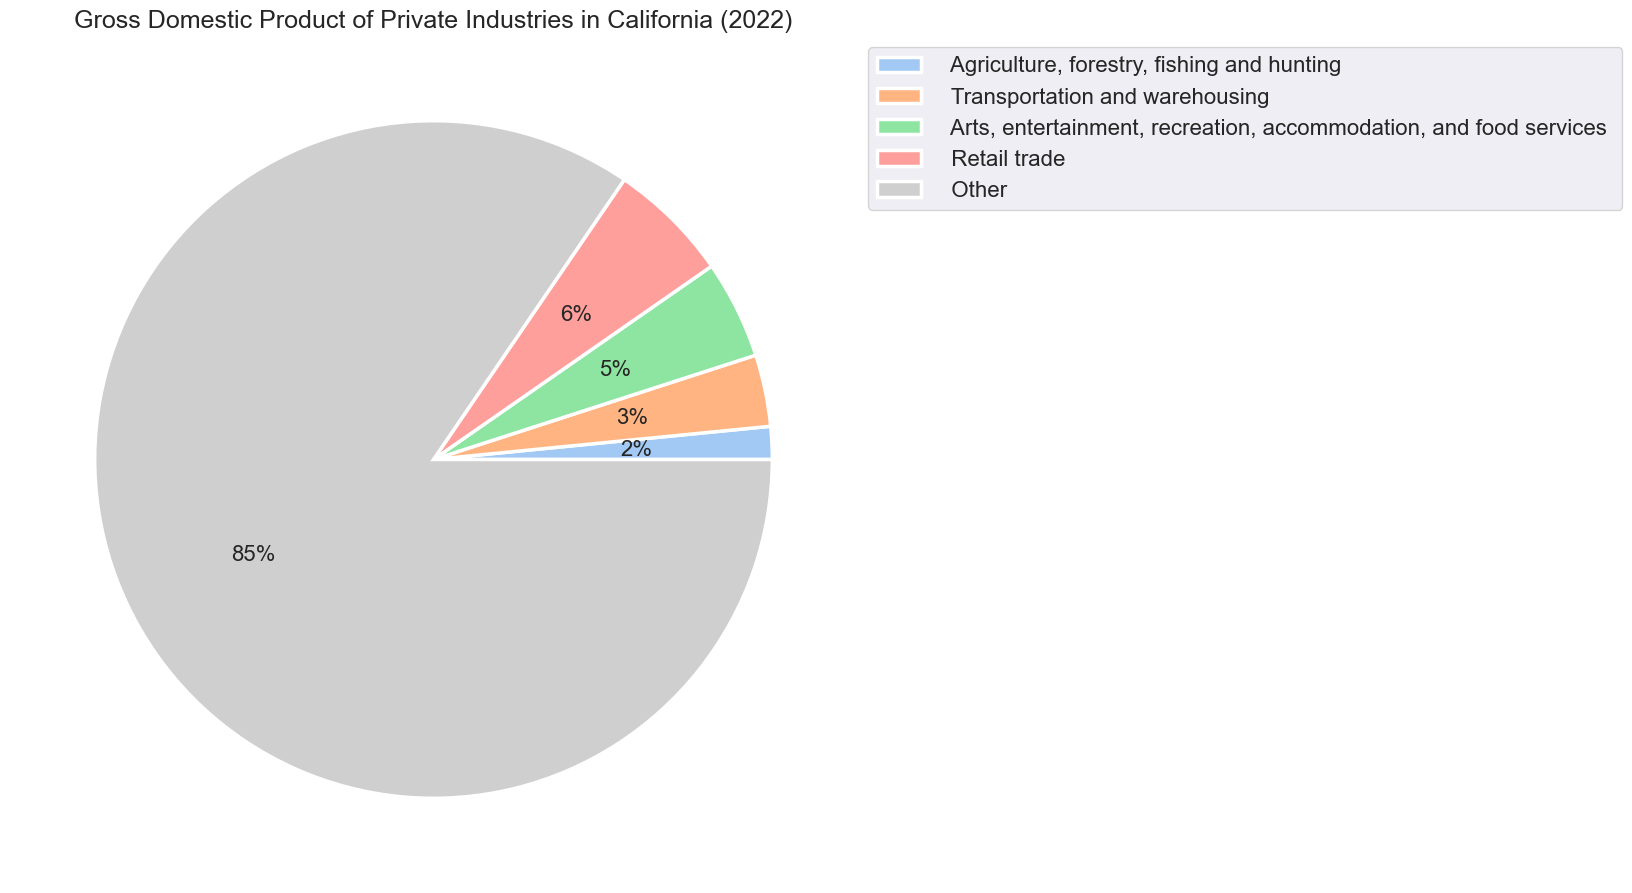

In [125]:
plot_gdp_pie_chart(sagdp2N_CA, "California")

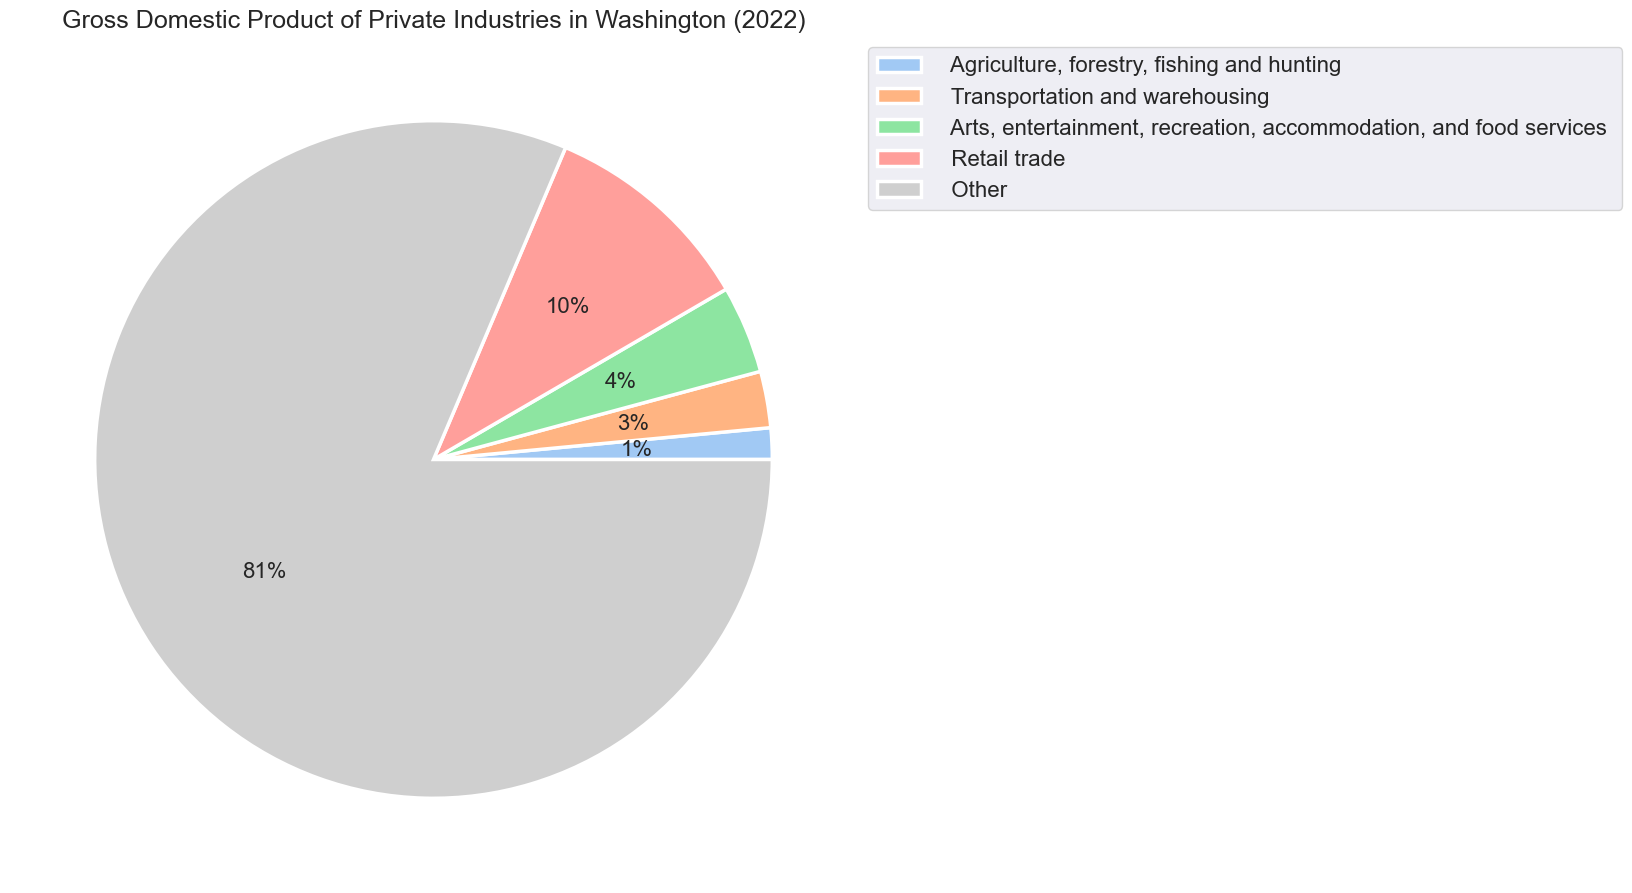

In [126]:
plot_gdp_pie_chart(sagdp2N_WA, "Washington")

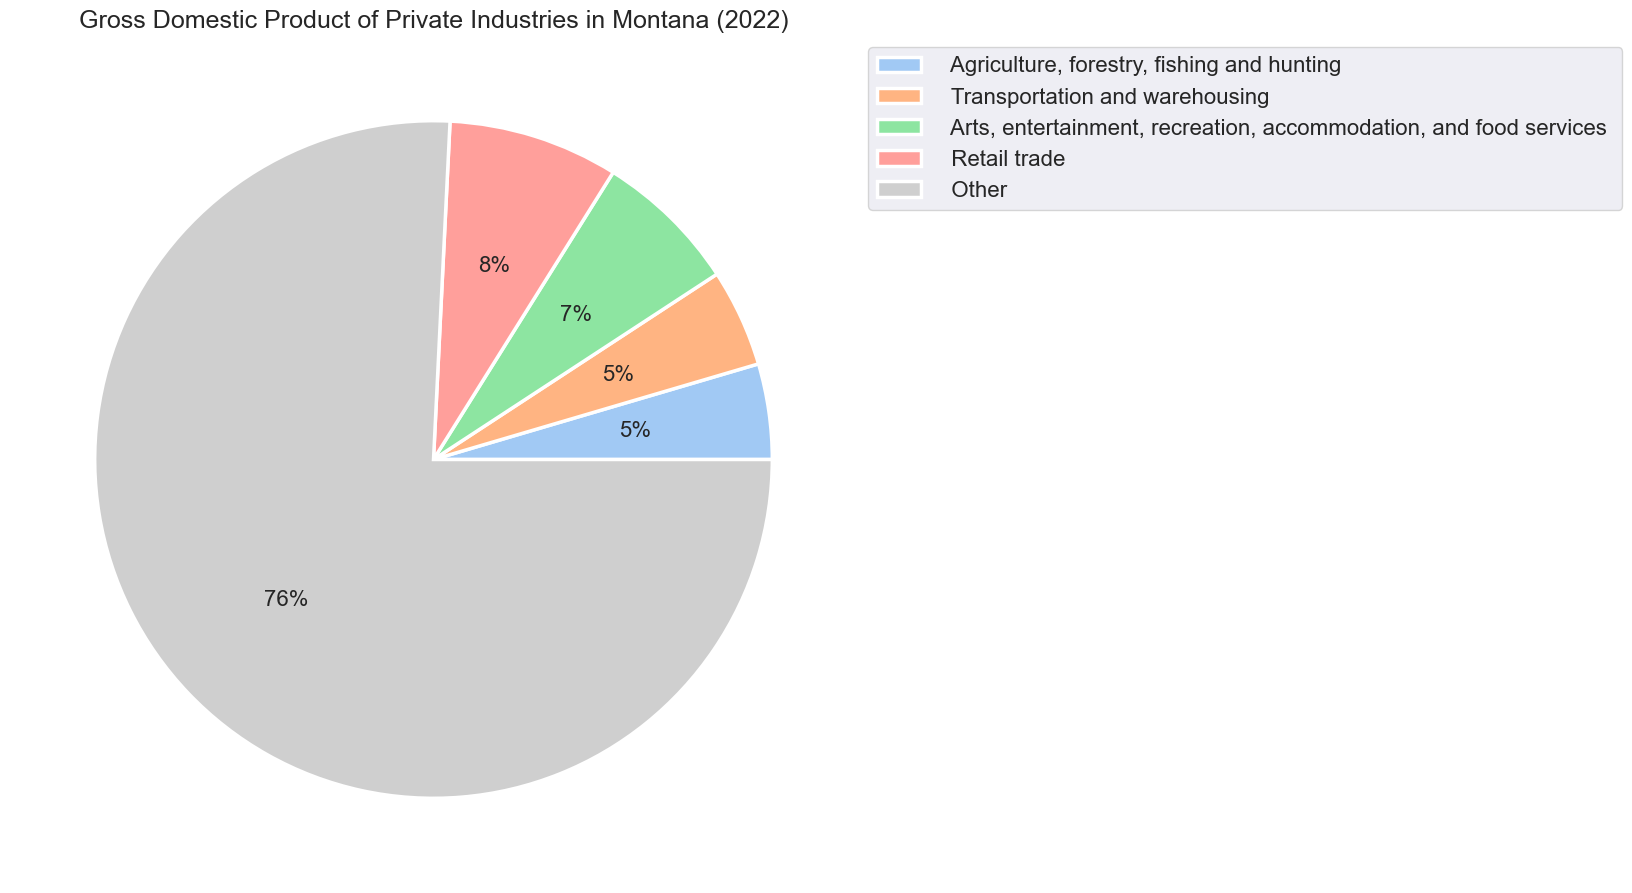

In [127]:
plot_gdp_pie_chart(sagdp2N_MT, "Montana")

### Step 2: Data Transformation
There are two main transformations that we need to do to clean the data. We currently have two data files: `SAGDP2N_MT_1997_2022.csv` and `SAGDP2S_MT_1963_1997.csv`. Like you would expect the first file contains GDP data from 1997 to 2022 and the second file, data from 1963 to 1997. We need to do the following: <br>

1. Extract outdoor recreation/tourism private industries
    - Agriculture, forestry, fishing, and hunting
    - Transportation and warehousing
    - Arts, entertainment, recreation, accomodation and food services
    - Retail trade
2. Join the GDP data together
    - We should have one single GDP file with data from 1963 to 1997

In [131]:
sagdp2n_mt_classes = ["11", "48-49", "71, 72", "44-45"]
sagdp2s_linecodes = [3, 37, 48, 58, 59, 63, 64]
# Selecting Agriculture, forestry and fishing GDP
outdoors1 = sagdp2S_MT[sagdp2S_MT['LineCode'].isin(sagdp2s_linecodes)]
outdoors2 = sagdp2N_MT[sagdp2N_MT['IndustryClassification'].isin(sagdp2n_mt_classes)]

# Merging years from 1963 to 2022
outdoors_melt1 = outdoors1.melt(id_vars='Description', value_vars=list(outdoors1.columns)[8:])
outdoors_melt2 = outdoors2.melt(id_vars='Description', value_vars=list(outdoors2.columns)[8:])

# Renaming columns
outdoors_melt1.columns = ['category', 'year', 'gdp']
outdoors_melt2.columns = ['category', 'year', 'gdp']

# convert gdp columns to floats
outdoors_melt1['gdp'] = outdoors_melt1['gdp'].astype(float)
outdoors_melt2['gdp'] = outdoors_melt2['gdp'].astype(float)

outdoors_melt1['year'] = outdoors_melt1['year'].astype(int)
outdoors_melt2['year'] = outdoors_melt2['year'].astype(int)

# Grouping the categories into a single gdp sum
outdoors_melt1_group = outdoors_melt1[['year', 'gdp']].groupby('year').sum()
outdoors_melt2_group = outdoors_melt2[['year', 'gdp']].groupby('year').sum()

gdp_df = pd.concat([outdoors_melt1_group.iloc[:-1, :], outdoors_melt2_group], axis=0).reset_index()
gdp_df.to_csv("../data_intermediate/montana_gdp.csv", index=False)